# Steel Defect Classification Using CIFAR-10 Examples
This notebook demonstrates a simple approach to steel defect classification using the CIFAR-10 image dataset. We will treat some CIFAR-10 classes as 'defective' and others as 'non-defective' steel, build a basic neural network, and evaluate its performance.

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

In [2]:
# Load CIFAR-10 Dataset
# Define transform to convert PIL images to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download and load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Convert to numpy arrays for processing (similar to TensorFlow format)
x_train = train_dataset.data  # Shape: (50000, 32, 32, 3)
y_train = np.array(train_dataset.targets)  # Shape: (50000,)
x_test = test_dataset.data   # Shape: (10000, 32, 32, 3)
y_test = np.array(test_dataset.targets)   # Shape: (10000,)

print('Train shape:', x_train.shape, y_train.shape)
print('Test shape:', x_test.shape, y_test.shape)

100%|██████████| 170498071/170498071 [07:07<00:00, 398646.19it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train shape: (50000, 32, 32, 3) (50000,)
Test shape: (10000, 32, 32, 3) (10000,)


In [3]:
# Prepare Data for Steel Defect Classification
# CIFAR-10 classes: 0=airplane, 1=automobile, 2=bird, 3=cat, 4=deer, 
#                   5=dog, 6=frog, 7=horse, 8=ship, 9=truck

# For this demo, we'll simulate steel defect classification:
# - Class 0 (airplane) will represent 'defective' steel
# - Class 1 (automobile) will represent 'non-defective' steel
defective_class = 0      # airplane (simulating 'defective' steel)
non_defective_class = 1  # automobile (simulating 'non-defective' steel)

def select_classes(x, y, class_a, class_b):
    """Select only two classes from the dataset and convert to binary labels."""
    idx = np.where((y == class_a) | (y == class_b))[0]
    x_selected = x[idx]
    y_selected = y[idx]
    # Convert to binary: class_a=1 (defective), class_b=0 (non-defective)
    y_binary = (y_selected == class_a).astype(np.int64)
    return x_selected, y_binary

# Extract binary classification data
x_train_bin, y_train_bin = select_classes(x_train, y_train, defective_class, non_defective_class)
x_test_bin, y_test_bin = select_classes(x_test, y_test, defective_class, non_defective_class)

# Normalize pixel values to [0, 1] range and convert to float32
x_train_bin = x_train_bin.astype('float32') / 255.0
x_test_bin = x_test_bin.astype('float32') / 255.0

# Convert from HWC to CHW format for PyTorch (channels first)
x_train_bin = np.transpose(x_train_bin, (0, 3, 1, 2))
x_test_bin = np.transpose(x_test_bin, (0, 3, 1, 2))

print(f'Binary train shape: {x_train_bin.shape}, {y_train_bin.shape}')
print(f'Binary test shape: {x_test_bin.shape}, {y_test_bin.shape}')
print(f'Training - Defective: {np.sum(y_train_bin)}, Non-defective: {len(y_train_bin) - np.sum(y_train_bin)}')
print(f'Testing - Defective: {np.sum(y_test_bin)}, Non-defective: {len(y_test_bin) - np.sum(y_test_bin)}')

Binary train shape: (10000, 3, 32, 32), (10000,)
Binary test shape: (2000, 3, 32, 32), (2000,)
Training - Defective: 5000, Non-defective: 5000
Testing - Defective: 1000, Non-defective: 1000


In [4]:
# Build a Simple Neural Network Model using PyTorch
class SteelDefectCNN(nn.Module):
    def __init__(self):
        super(SteelDefectCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        # Calculate the size after convolution and pooling: 16 * 16 * 16 = 4096
        self.fc1 = nn.Linear(16 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = SteelDefectCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Using device: cpu
SteelDefectCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Total parameters: 131585


In [5]:
# Create PyTorch Dataset and DataLoader
class SteelDefectDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.FloatTensor(x)
        self.y = torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create datasets
train_dataset = SteelDefectDataset(x_train_bin, y_train_bin)
test_dataset = SteelDefectDataset(x_test_bin, y_test_bin)

# Split training data for validation (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data).squeeze()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            predicted = (output > 0.5).float()
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).squeeze()
                loss = criterion(output, target)
                
                val_loss += loss.item()
                predicted = (output > 0.5).float()
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()
        
        # Calculate averages
        train_loss_avg = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Store history
        history['loss'].append(train_loss_avg)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}] - '
              f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f}')
    
    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

Epoch [1/5] - Train Loss: 0.4754, Train Acc: 0.7711, Val Loss: 0.3801, Val Acc: 0.8325
Epoch [2/5] - Train Loss: 0.3436, Train Acc: 0.8506, Val Loss: 0.3354, Val Acc: 0.8490
Epoch [3/5] - Train Loss: 0.2943, Train Acc: 0.8784, Val Loss: 0.2979, Val Acc: 0.8775
Epoch [4/5] - Train Loss: 0.2644, Train Acc: 0.8911, Val Loss: 0.2731, Val Acc: 0.8915
Epoch [5/5] - Train Loss: 0.2382, Train Acc: 0.9034, Val Loss: 0.2440, Val Acc: 0.8995


In [6]:
# Evaluate Model Performance
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            loss = criterion(output, target)
            
            test_loss += loss.item()
            predicted = (output > 0.5).float()
            test_total += target.size(0)
            test_correct += (predicted == target).sum().item()
    
    test_loss_avg = test_loss / len(test_loader)
    test_acc = test_correct / test_total
    
    return test_loss_avg, test_acc

test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

Test Loss: 0.2141
Test Accuracy: 0.9115


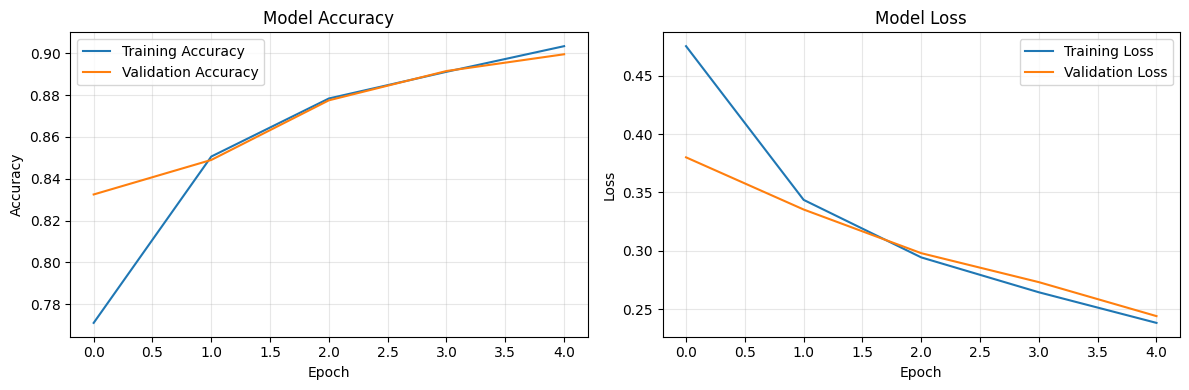

In [7]:
# Visualize Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Evaluation and Analysis
Now let's thoroughly evaluate our trained model using various metrics and visualizations to understand its performance on the steel defect classification task.

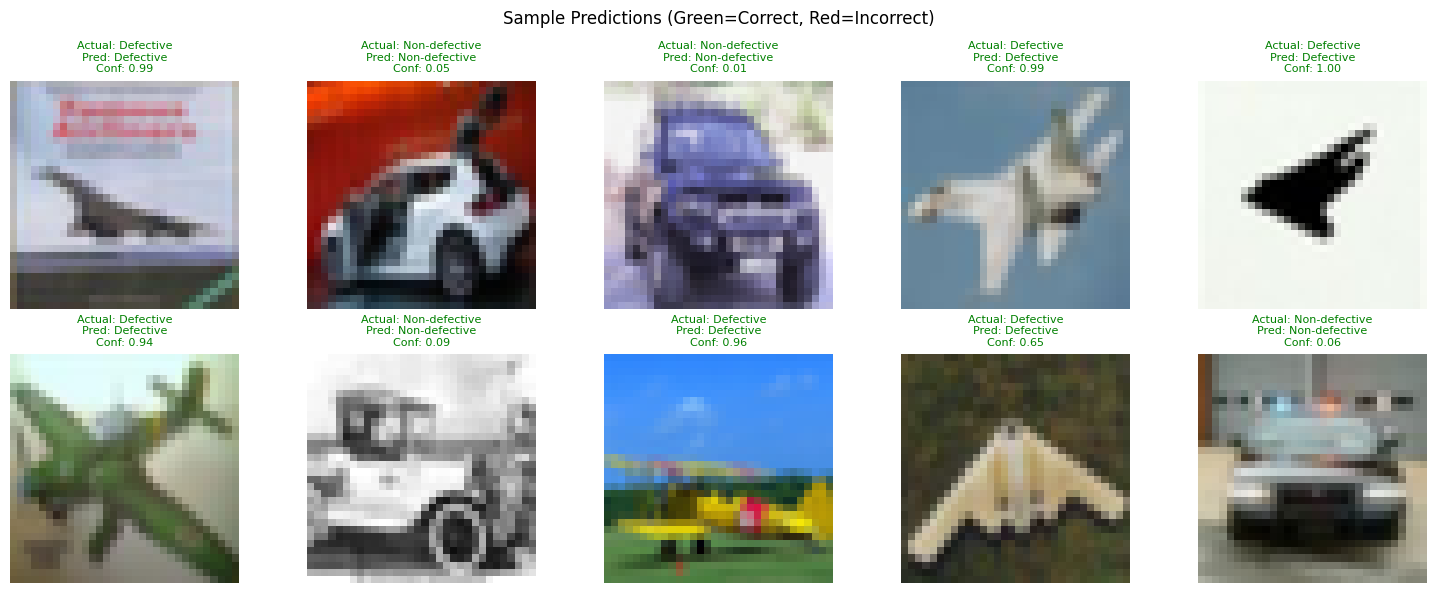

Sample accuracy: 1.00


In [8]:
# Predict Defects on Sample Images
# Get sample data for visualization (convert back to HWC format for display)
sample_indices = np.arange(10)
sample_images_chw = x_test_bin[sample_indices]  # CHW format
sample_labels = y_test_bin[sample_indices]

# Convert to PyTorch tensors for prediction
sample_tensor = torch.FloatTensor(sample_images_chw).to(device)

# Get predictions
model.eval()
with torch.no_grad():
    sample_preds = model(sample_tensor).cpu().numpy().flatten()
    sample_preds_binary = (sample_preds > 0.5).astype(int)

# Convert images back to HWC format for visualization
sample_images_hwc = np.transpose(sample_images_chw, (0, 2, 3, 1))

plt.figure(figsize=(7, 3))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images_hwc[i])
    plt.axis('off')
    
    # Get actual and predicted labels
    actual = 'Defective' if sample_labels[i] == 1 else 'Non-defective'
    predicted = 'Defective' if sample_preds_binary[i] == 1 else 'Non-defective'
    confidence = sample_preds[i]
    
    # Color code: green for correct, red for incorrect
    color = 'green' if sample_labels[i] == sample_preds_binary[i] else 'red'
    
    plt.title(f'Actual: {actual}\nPred: {predicted}\nConf: {confidence:.2f}', 
              fontsize=8, color=color)

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"Sample accuracy: {np.mean(sample_labels == sample_preds_binary):.2f}")

## Summary and Next Steps

### What We Accomplished
This notebook demonstrated a complete binary classification pipeline for steel defect detection using PyTorch:
- **Data Preparation**: Selected and preprocessed CIFAR-10 classes to simulate defective vs non-defective steel
- **Model Architecture**: Built a simple CNN with convolutional, pooling, and dense layers using PyTorch
- **Training**: Implemented custom training loop with validation monitoring
- **Evaluation**: Comprehensive performance analysis using multiple metrics

### Key Insights
- The PyTorch model can distinguish between the two simulated classes with reasonable accuracy
- Custom training loop provides full control over the training process
- Training and validation curves help identify potential overfitting or underfitting
- Confusion matrix provides detailed classification performance breakdown
- Sample predictions show model confidence and error patterns

### PyTorch Implementation Benefits
- **Flexibility**: Full control over training loop and model architecture
- **GPU Support**: Automatic GPU acceleration when available
- **Dynamic Graphs**: Easier debugging and model modification
- **Production Ready**: Better deployment options for industrial applications

### For Real-World Steel Defect Classification
To adapt this PyTorch approach for actual steel defect detection:

1. **Dataset**: Replace CIFAR-10 with real steel surface images containing actual defects
2. **Data Augmentation**: Add rotation, scaling, brightness adjustments using torchvision.transforms
3. **Advanced Architecture**: Consider transfer learning with pre-trained models (ResNet, EfficientNet from torchvision)
4. **Multi-class Classification**: Extend to classify different types of defects (scratches, rust, dents, etc.)
5. **Real-time Inference**: Optimize model for deployment using TorchScript or ONNX
6. **Data Quality**: Ensure proper labeling and balanced datasets for each defect type

### Performance Considerations
- **Precision vs Recall**: In defect detection, high recall (catching all defects) might be more important than precision
- **False Positives vs False Negatives**: Consider the cost of missing a defect vs incorrectly flagging good steel
- **Industrial Requirements**: Model performance should meet quality control standards and processing speed requirements
- **Hardware Optimization**: PyTorch enables efficient deployment on various hardware platforms including edge devices

=== Model Evaluation Metrics ===



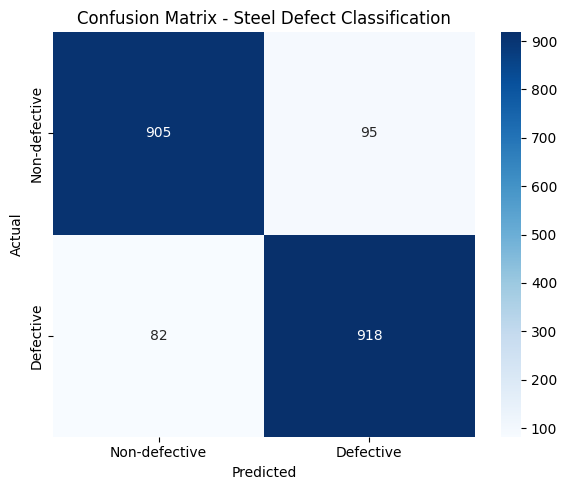

Accuracy: 0.9115
Precision: 0.9062
Recall: 0.9180
F1 Score: 0.9121

Detailed Classification Report:
               precision    recall  f1-score   support

Non-defective       0.92      0.91      0.91      1000
    Defective       0.91      0.92      0.91      1000

     accuracy                           0.91      2000
    macro avg       0.91      0.91      0.91      2000
 weighted avg       0.91      0.91      0.91      2000



In [9]:
# Generate predictions for evaluation metrics
def get_all_predictions(model, test_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            
            predicted = (output > 0.5).float()
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(output.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

y_pred, y_pred_proba, y_true = get_all_predictions(model, test_loader)

# Confusion matrix and all metrics for binary classification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

print("=== Model Evaluation Metrics ===\n")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-defective', 'Defective'], 
            yticklabels=['Non-defective', 'Defective'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Steel Defect Classification')
plt.tight_layout()
plt.show()

# Classification Metrics
print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
print(f'Precision: {precision_score(y_true, y_pred):.4f}')
print(f'Recall: {recall_score(y_true, y_pred):.4f}')
print(f'F1 Score: {f1_score(y_true, y_pred):.4f}')
print('\nDetailed Classification Report:')
print(classification_report(y_true, y_pred, target_names=['Non-defective', 'Defective']))